In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
from time import time


# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import copy
import pandas as pd
import numpy as np
import os

PRJ_ROOT_DIR = os.path.dirname(os.path.abspath(''))

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import heapq

## LDA Data

### Load data

In [443]:
df = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "matches.csv"))
df

,home_result,season,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,...,2_23,0_24,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26
0,lose,2019/20,1.286584,7.035507,1.259102,-2.931753,0.062317,-1.631287,-2.707726,-0.607117,...,-100.000000,2.247774,-0.737455,-1.588368,2.059278,-1.289581,-0.214014,-0.025312,-0.479952,1.471758
1,win,2019/20,0.771112,2.864098,0.136227,-3.137167,-0.522932,-0.568367,-2.725580,-0.359102,...,-0.780148,1.990417,-0.727778,-2.796785,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
2,win,2019/20,1.081934,6.476357,1.060024,-3.610155,-0.617447,3.083772,-3.131397,-0.594232,...,2.718124,2.234902,-0.764160,-0.524770,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
3,win,2019/20,1.270547,6.125389,0.866984,-3.375562,-0.538387,-1.682440,-3.103326,0.157253,...,-100.000000,1.980681,-0.619516,-1.541976,1.383543,-0.932270,0.070167,1.083550,-0.641444,1.485667
4,win,2019/20,1.446074,7.081245,1.423544,-3.169787,-0.700700,0.751141,-2.441979,-0.588787,...,0.878456,2.518209,-0.529214,-3.471708,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,win,2021/22,1.096860,7.664981,1.030113,-3.110702,-0.419559,0.173017,-2.291735,-0.189176,...,-1.604356,2.068204,-0.881599,-1.226240,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
1136,win,2021/22,0.334105,3.979458,0.309591,-3.123301,-0.053396,-0.840144,-2.975121,-0.110232,...,-0.690187,2.041043,-1.006175,-3.622045,1.180349,-0.571187,-1.254287,-100.000000,-100.000000,-100.000000
1137,lose,2021/22,0.935548,6.279345,0.752885,-2.725118,-0.222117,-0.084760,-2.359624,-0.233390,...,-100.000000,2.089158,-0.930276,-3.477027,1.293585,-1.183664,2.243419,1.281312,-0.590887,0.282728
1138,win,2021/22,1.182444,7.042481,0.819191,-2.873911,-0.669088,0.491676,-2.763736,-0.132193,...,0.762411,1.627330,-1.141200,-1.083433,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000


Replace -100 to min of columns

In [444]:
for i in df.columns:
    df[i].replace({-100 : min(df[df[i] != -100][i])}, inplace = True)
#     df[i].replace({-100 : 0}, inplace = True)
    
df


,home_result,season,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,...,2_23,0_24,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26
0,lose,2019/20,1.286584,7.035507,1.259102,-2.931753,0.062317,-1.631287,-2.707726,-0.607117,...,-1.983529,2.247774,-0.737455,-1.588368,2.059278,-1.289581,-0.214014,-0.025312,-0.479952,1.471758
1,win,2019/20,0.771112,2.864098,0.136227,-3.137167,-0.522932,-0.568367,-2.725580,-0.359102,...,-0.780148,1.990417,-0.727778,-2.796785,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759
2,win,2019/20,1.081934,6.476357,1.060024,-3.610155,-0.617447,3.083772,-3.131397,-0.594232,...,2.718124,2.234902,-0.764160,-0.524770,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759
3,win,2019/20,1.270547,6.125389,0.866984,-3.375562,-0.538387,-1.682440,-3.103326,0.157253,...,-1.983529,1.980681,-0.619516,-1.541976,1.383543,-0.932270,0.070167,1.083550,-0.641444,1.485667
4,win,2019/20,1.446074,7.081245,1.423544,-3.169787,-0.700700,0.751141,-2.441979,-0.588787,...,0.878456,2.518209,-0.529214,-3.471708,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,win,2021/22,1.096860,7.664981,1.030113,-3.110702,-0.419559,0.173017,-2.291735,-0.189176,...,-1.604356,2.068204,-0.881599,-1.226240,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759
1136,win,2021/22,0.334105,3.979458,0.309591,-3.123301,-0.053396,-0.840144,-2.975121,-0.110232,...,-0.690187,2.041043,-1.006175,-3.622045,1.180349,-0.571187,-1.254287,-2.726078,-2.250698,-1.944759
1137,lose,2021/22,0.935548,6.279345,0.752885,-2.725118,-0.222117,-0.084760,-2.359624,-0.233390,...,-1.983529,2.089158,-0.930276,-3.477027,1.293585,-1.183664,2.243419,1.281312,-0.590887,0.282728
1138,win,2021/22,1.182444,7.042481,0.819191,-2.873911,-0.669088,0.491676,-2.763736,-0.132193,...,0.762411,1.627330,-1.141200,-1.083433,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759


## Outline removal

### Visualization

In [445]:
# plt.figure(figsize=(80, 100))
# pd.plotting.scatter_matrix(df[df.columns[:-2]])
# plt.show()

## Isolation Forest

### Clustering

In [446]:
from sklearn.cluster import OPTICS, DBSCAN, Birch
import numpy as np

df['cluster'] = DBSCAN(min_samples=2, eps = 8.5).fit_predict(df[df.columns[2:]])
df.drop(df[df['cluster'] == -1].index, inplace=True)
df.reset_index(inplace = True, drop = True)
df

,home_result,season,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,...,0_24,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26,cluster
0,lose,2019/20,1.286584,7.035507,1.259102,-2.931753,0.062317,-1.631287,-2.707726,-0.607117,...,2.247774,-0.737455,-1.588368,2.059278,-1.289581,-0.214014,-0.025312,-0.479952,1.471758,0
1,win,2019/20,0.771112,2.864098,0.136227,-3.137167,-0.522932,-0.568367,-2.725580,-0.359102,...,1.990417,-0.727778,-2.796785,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759,0
2,win,2019/20,1.081934,6.476357,1.060024,-3.610155,-0.617447,3.083772,-3.131397,-0.594232,...,2.234902,-0.764160,-0.524770,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759,0
3,win,2019/20,1.270547,6.125389,0.866984,-3.375562,-0.538387,-1.682440,-3.103326,0.157253,...,1.980681,-0.619516,-1.541976,1.383543,-0.932270,0.070167,1.083550,-0.641444,1.485667,0
4,win,2019/20,1.446074,7.081245,1.423544,-3.169787,-0.700700,0.751141,-2.441979,-0.588787,...,2.518209,-0.529214,-3.471708,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,win,2021/22,1.096860,7.664981,1.030113,-3.110702,-0.419559,0.173017,-2.291735,-0.189176,...,2.068204,-0.881599,-1.226240,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759,0
1113,win,2021/22,0.334105,3.979458,0.309591,-3.123301,-0.053396,-0.840144,-2.975121,-0.110232,...,2.041043,-1.006175,-3.622045,1.180349,-0.571187,-1.254287,-2.726078,-2.250698,-1.944759,0
1114,lose,2021/22,0.935548,6.279345,0.752885,-2.725118,-0.222117,-0.084760,-2.359624,-0.233390,...,2.089158,-0.930276,-3.477027,1.293585,-1.183664,2.243419,1.281312,-0.590887,0.282728,0
1115,win,2021/22,1.182444,7.042481,0.819191,-2.873911,-0.669088,0.491676,-2.763736,-0.132193,...,1.627330,-1.141200,-1.083433,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759,0


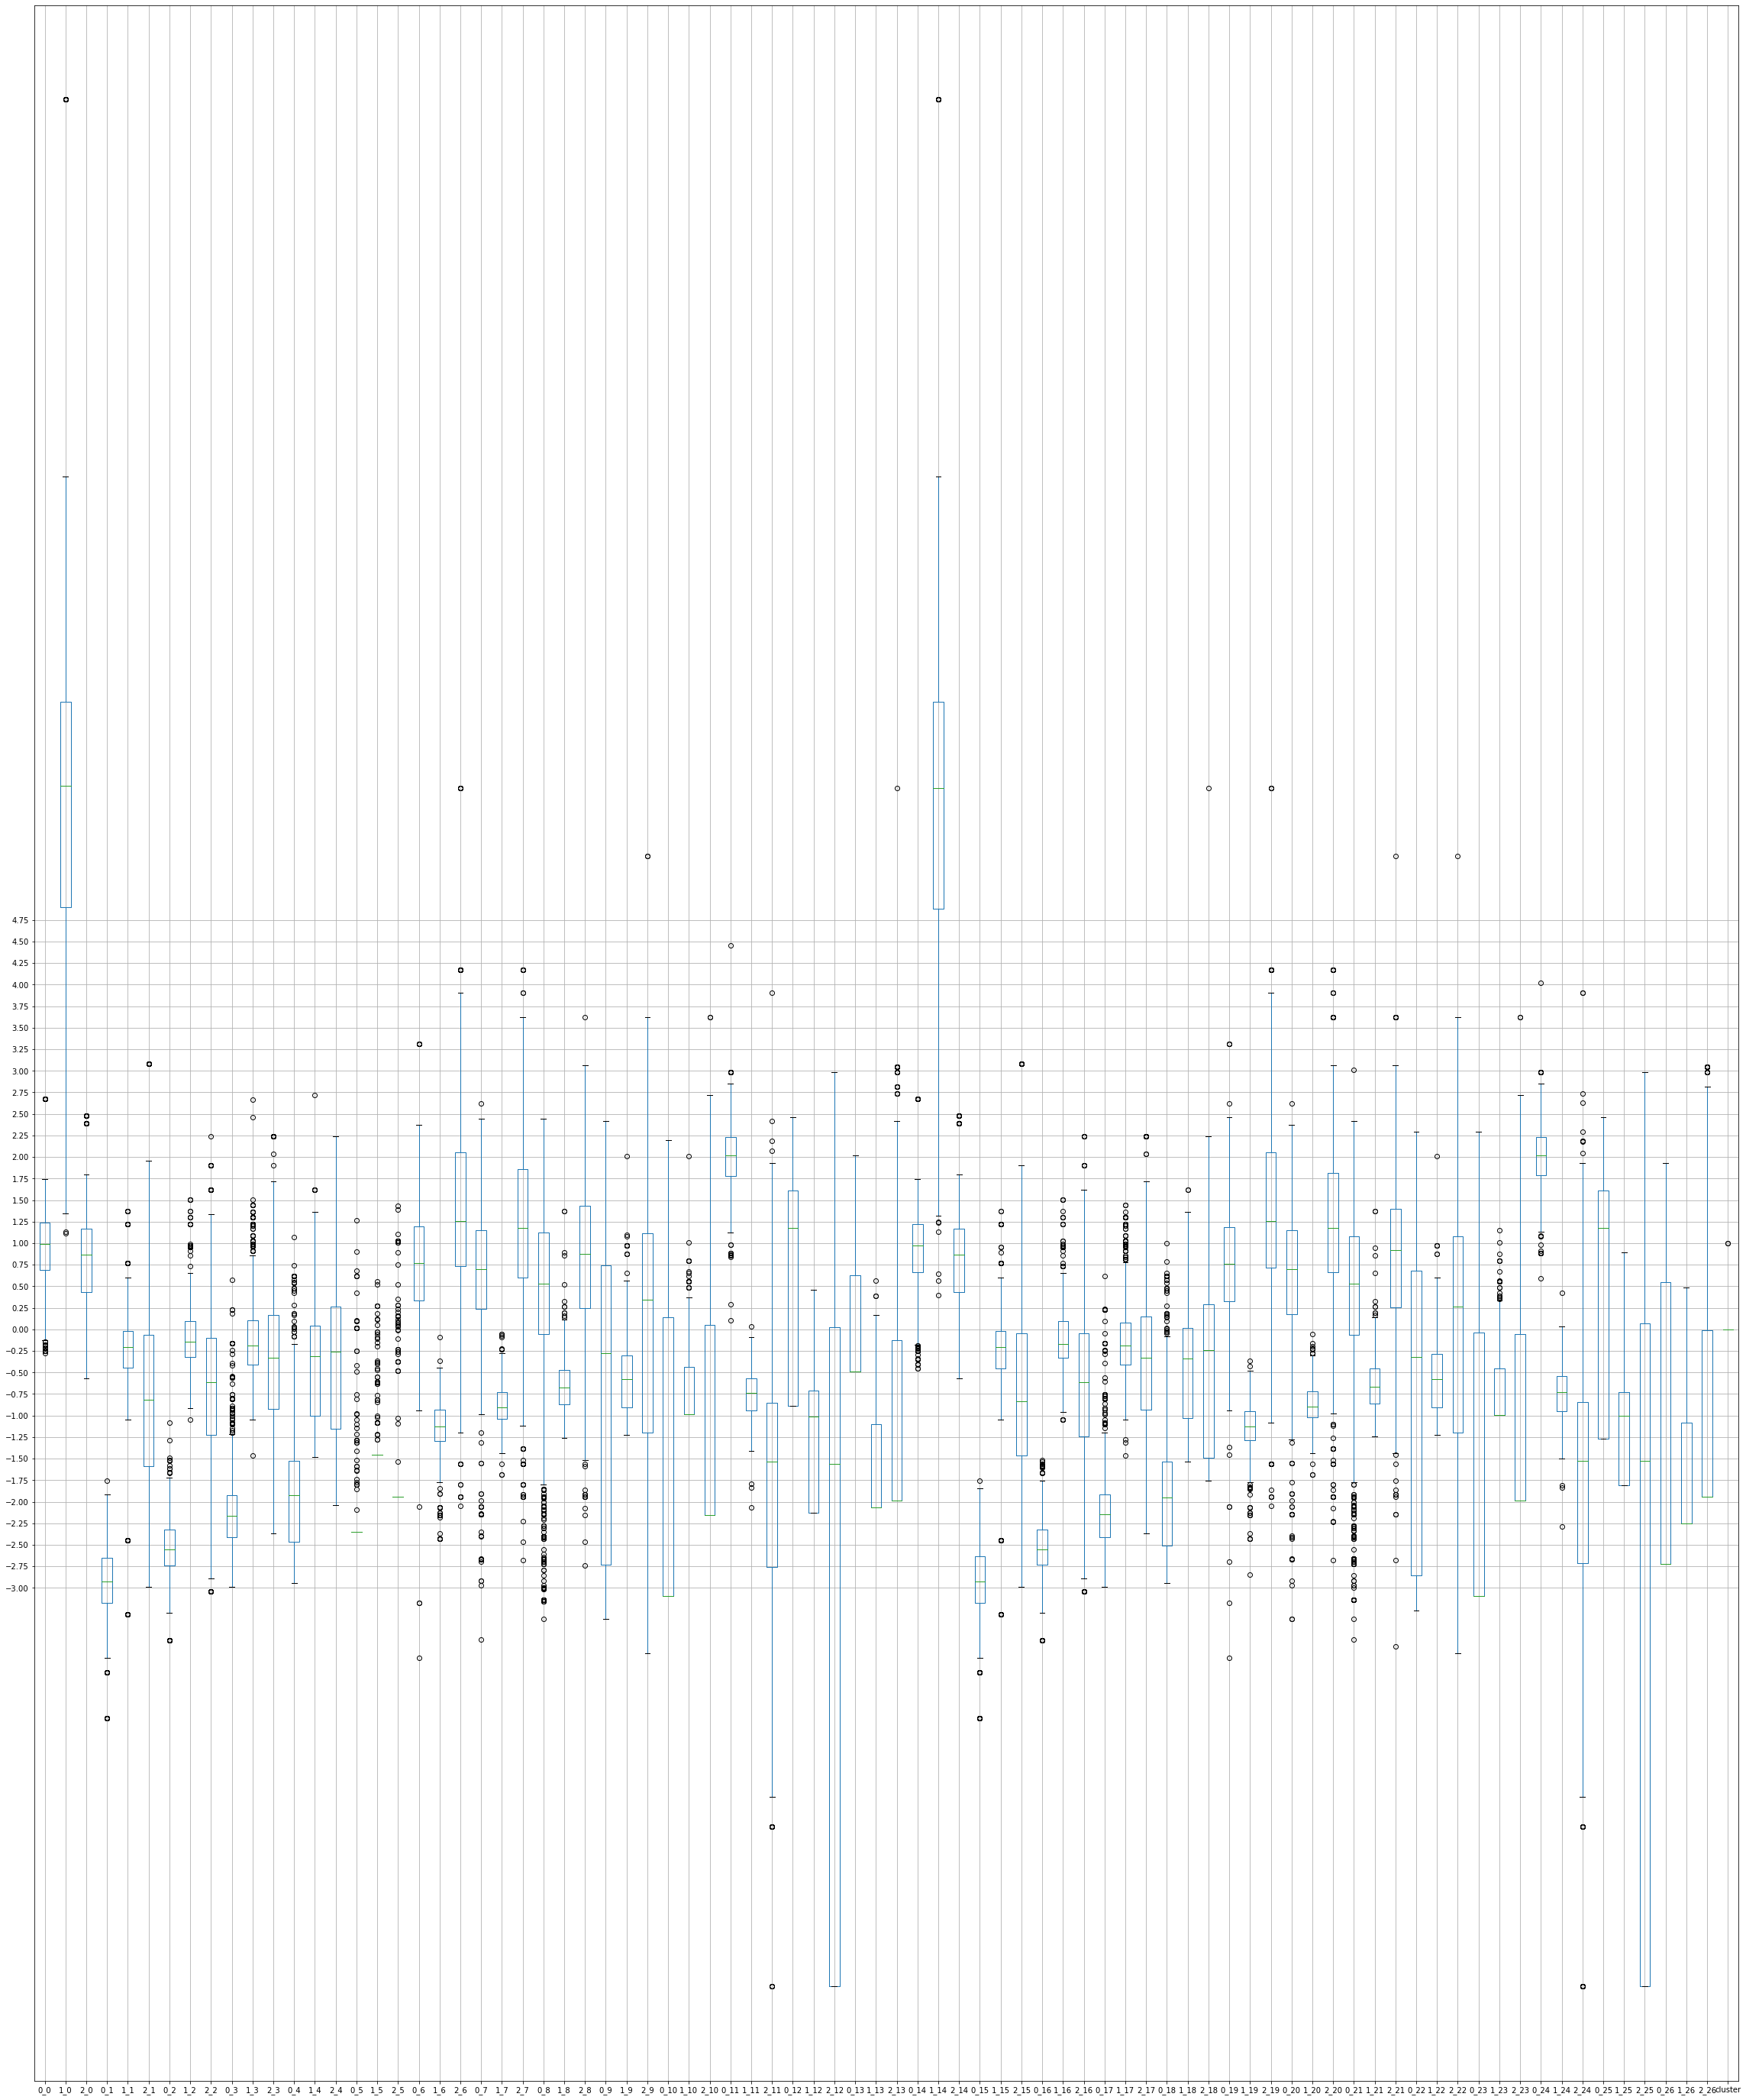

In [447]:
ax = df[df.columns[2:]].boxplot(figsize=(40,50))
plt.yticks([i/4 for i in range(-3*4,5*4)])
plt.show()

### Boxplot

In [448]:
columns = df.columns[2:-1]
upper = []
lower = []
for i in columns :
    
    Q1 = np.percentile(df[i], 25,
                       interpolation = 'midpoint')

    Q3 = np.percentile(df[i], 75,
                       interpolation = 'midpoint')
    IQR = Q3 - Q1

    # Upper bound
    upper += np.where(df[i] >= (Q3+1.5*IQR))[0].tolist()
#     print(upper)
    # Lower bound
    lower += np.where(df[i] <= (Q1-1.5*IQR))[0].tolist()

    ''' Removing the Outliers '''
index = upper+ lower
frq = [index.count(i) for i in range(len(df))]
# print([frq[i] for i in range(len(frq)) if frq[i] in heapq.nlargest(4, set(frq)) ])
df.drop([i for i in range(len(frq)) if frq[i] in heapq.nlargest(2, set(frq)) ], inplace = True)
df.reset_index(inplace = True, drop = True)
df

,home_result,season,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,...,0_24,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26,cluster
0,lose,2019/20,1.286584,7.035507,1.259102,-2.931753,0.062317,-1.631287,-2.707726,-0.607117,...,2.247774,-0.737455,-1.588368,2.059278,-1.289581,-0.214014,-0.025312,-0.479952,1.471758,0
1,win,2019/20,0.771112,2.864098,0.136227,-3.137167,-0.522932,-0.568367,-2.725580,-0.359102,...,1.990417,-0.727778,-2.796785,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759,0
2,win,2019/20,1.081934,6.476357,1.060024,-3.610155,-0.617447,3.083772,-3.131397,-0.594232,...,2.234902,-0.764160,-0.524770,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759,0
3,win,2019/20,1.270547,6.125389,0.866984,-3.375562,-0.538387,-1.682440,-3.103326,0.157253,...,1.980681,-0.619516,-1.541976,1.383543,-0.932270,0.070167,1.083550,-0.641444,1.485667,0
4,win,2019/20,1.446074,7.081245,1.423544,-3.169787,-0.700700,0.751141,-2.441979,-0.588787,...,2.518209,-0.529214,-3.471708,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,win,2021/22,1.096860,7.664981,1.030113,-3.110702,-0.419559,0.173017,-2.291735,-0.189176,...,2.068204,-0.881599,-1.226240,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759,0
1103,win,2021/22,0.334105,3.979458,0.309591,-3.123301,-0.053396,-0.840144,-2.975121,-0.110232,...,2.041043,-1.006175,-3.622045,1.180349,-0.571187,-1.254287,-2.726078,-2.250698,-1.944759,0
1104,lose,2021/22,0.935548,6.279345,0.752885,-2.725118,-0.222117,-0.084760,-2.359624,-0.233390,...,2.089158,-0.930276,-3.477027,1.293585,-1.183664,2.243419,1.281312,-0.590887,0.282728,0
1105,win,2021/22,1.182444,7.042481,0.819191,-2.873911,-0.669088,0.491676,-2.763736,-0.132193,...,1.627330,-1.141200,-1.083433,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759,0


Scale

In [449]:
from sklearn.preprocessing import StandardScaler

df_scale =df[df.columns[2:-1]]
scaler = StandardScaler()
df_scale=scaler.fit_transform(df[df.columns[2:-1]])
df_scale = pd.DataFrame(df_scale, columns = df.columns[2:-1])
df_scale[['result','season'] ] = df[['home_result', 'season']]
df_scale


,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,2_2,0_3,...,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26,result,season
0,0.690128,0.436890,0.733371,0.046905,0.622259,-0.862636,-0.453401,-1.402416,1.223521,-1.151248,...,0.051337,0.115652,1.162228,-0.253610,0.717699,0.864097,1.862079,1.645145,lose,2019/20
1,-0.362479,-1.648317,-1.063727,-0.408618,-0.406705,0.135320,-0.501961,-0.699135,0.587550,1.123179,...,0.085390,-0.649728,-1.322993,-1.192099,-1.279460,-0.698003,-0.664956,-0.634648,win,2019/20
2,0.272228,0.157382,0.414758,-1.457510,-0.572878,3.564245,-1.605715,-1.365879,2.528363,-0.278466,...,-0.042638,0.789307,-1.322993,-1.192099,-1.279460,-0.698003,-0.664956,-0.634648,win,2019/20
3,0.657380,-0.018061,0.105809,-0.937279,-0.433877,-0.910662,-1.529368,0.765061,-1.682667,0.216521,...,0.466361,0.145035,0.657071,0.391254,0.794281,1.505454,1.631613,1.654426,win,2019/20
4,1.015809,0.459754,0.996551,-0.480955,-0.719251,1.374181,0.269386,-1.350441,-0.871904,-0.389449,...,0.784135,-1.077207,-1.322993,-1.192099,-1.279460,-0.698003,-0.664956,-0.634648,win,2019/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,0.302706,0.751552,0.366887,-0.349928,-0.224958,0.831392,0.678023,-0.217289,0.278745,-0.159140,...,-0.455904,0.345014,-1.322993,-1.192099,-1.279460,-0.698003,-0.664956,-0.634648,win,2021/22
1103,-1.254857,-1.090770,-0.786268,-0.377869,0.418818,-0.119846,-1.180671,0.006570,1.025095,0.984892,...,-0.894289,-1.172426,0.505171,1.042926,0.437363,-0.698003,-0.664956,-0.634648,win,2021/22
1104,-0.026697,0.058899,-0.076801,0.505136,0.122178,0.589369,0.493377,-0.342662,1.191154,1.097506,...,-0.627198,-1.080576,0.589822,-0.062455,1.379935,1.619838,1.703764,0.851722,lose,2021/22
1105,0.477471,0.440376,0.029317,0.175176,-0.663671,1.130575,-0.605741,-0.055704,0.888219,-0.037786,...,-1.369442,0.435464,-1.322993,-1.192099,-1.279460,-0.698003,-0.664956,-0.634648,win,2021/22


### Attribute selection

Feature: 0, Score: 0.01379
Feature: 1, Score: 0.01146
Feature: 2, Score: 0.01081
Feature: 3, Score: 0.01222
Feature: 4, Score: 0.01406
Feature: 5, Score: 0.01429
Feature: 6, Score: 0.01327
Feature: 7, Score: 0.01315
Feature: 8, Score: 0.01240
Feature: 9, Score: 0.01241
Feature: 10, Score: 0.01400
Feature: 11, Score: 0.01239
Feature: 12, Score: 0.01016
Feature: 13, Score: 0.01103
Feature: 14, Score: 0.01203
Feature: 18, Score: 0.01305
Feature: 19, Score: 0.01264
Feature: 20, Score: 0.01269
Feature: 21, Score: 0.01543
Feature: 22, Score: 0.01261
Feature: 23, Score: 0.02038
Feature: 24, Score: 0.01332
Feature: 25, Score: 0.01267
Feature: 26, Score: 0.01231
Feature: 27, Score: 0.01286
Feature: 28, Score: 0.01178
Feature: 29, Score: 0.01153
Feature: 33, Score: 0.01271
Feature: 34, Score: 0.01484
Feature: 35, Score: 0.01212
Feature: 42, Score: 0.01287
Feature: 43, Score: 0.01125
Feature: 44, Score: 0.01155
Feature: 45, Score: 0.01237
Feature: 46, Score: 0.01488
Feature: 47, Score: 0.01754
Fe

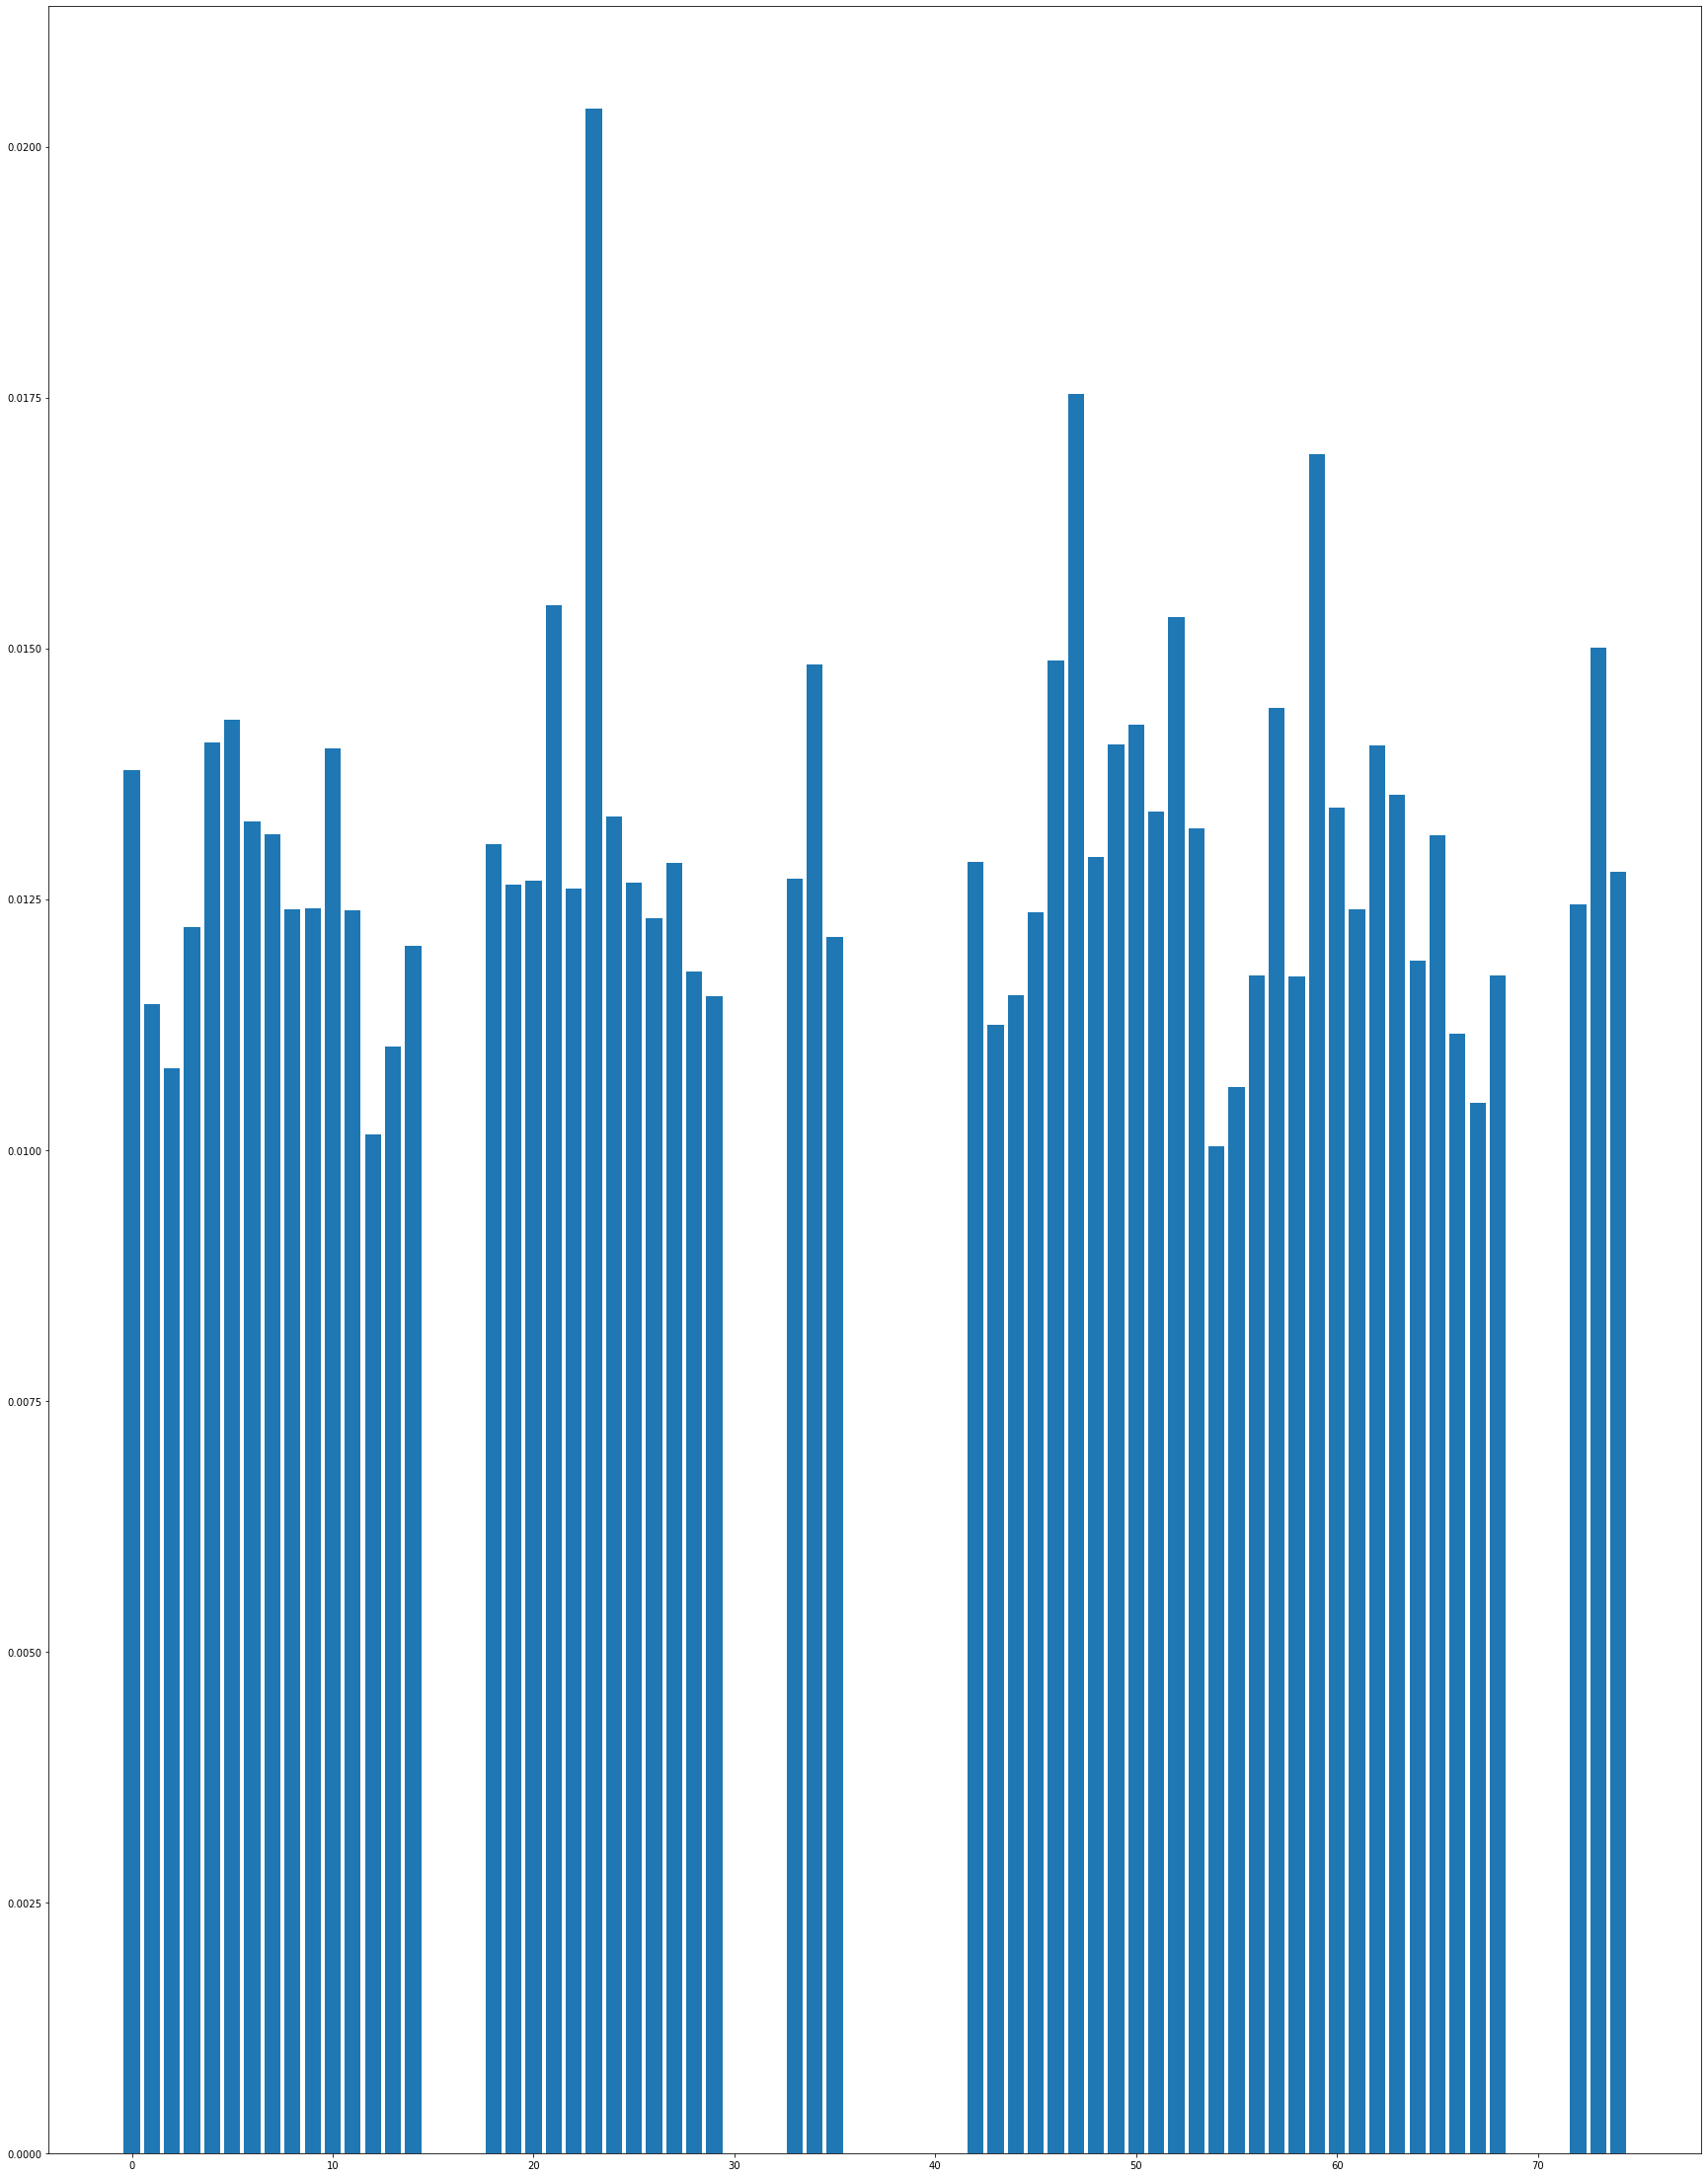

In [432]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
# prepare data 
from sklearn.model_selection import train_test_split, cross_val_predict, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

X = df_scale.iloc[:,:-2]
y = df_scale.iloc[:, -2].replace({'win': 1, 'lose': 0, 'draw': 2})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)  # train and test set
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=.1, random_state=42)  # train and dev set

# X_train = X_train.iloc[:,:-6]
importance = np.zeros((1,81))
for i in range(10):
#     model = XGBClassifier()
    model = RandomForestClassifier()
    # fit the model
    model.fit(X_train, y_train)
    # get importance
    importance = np.concatenate((importance,[model.feature_importances_]), axis =0)
importance = importance.mean(axis =0 )
thes = 0.01
# summarize feature importance
idx = []
for i,v in enumerate(importance):
    if v > thes :
        idx.append(i)
        print('Feature: %0d, Score: %.5f' % (i,v))
print(len(idx),idx)
# plot feature importance
plt.figure(figsize=(30,40))
plt.bar([x for x in range(len(importance))if importance[x] >thes], [x for x in importance if x >thes])
plt.show()

### Stratify data via season and result

In [433]:
df = df_scale[df_scale.columns[idx+ [-2,-1]]]
df

,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,2_2,0_3,...,1_21,2_21,0_22,1_22,2_22,0_24,1_24,2_24,result,season
0,0.690128,0.436890,0.733371,0.046905,0.622259,-0.862636,-0.453401,-1.402416,1.223521,-1.151248,...,0.122721,-0.116732,-1.356585,-1.370935,-1.638074,0.703665,0.051337,0.115652,lose,2019/20
1,-0.362479,-1.648317,-1.063727,-0.408618,-0.406705,0.135320,-0.501961,-0.699135,0.587550,1.123179,...,-0.948971,0.191139,1.744379,-0.241587,0.669773,-0.021885,0.085390,-0.649728,win,2019/20
2,0.272228,0.157382,0.414758,-1.457510,-0.572878,3.564245,-1.605715,-1.365879,2.528363,-0.278466,...,0.468277,0.262774,1.101608,0.434713,0.305630,0.667375,-0.042638,0.789307,win,2019/20
3,0.657380,-0.018061,0.105809,-0.937279,-0.433877,-0.910662,-1.529368,0.765061,-1.682667,0.216521,...,0.652225,0.573560,-0.859127,0.351249,0.089200,-0.049334,0.466361,0.145035,win,2019/20
4,1.015809,0.459754,0.996551,-0.480955,-0.719251,1.374181,0.269386,-1.350441,-0.871904,-0.389449,...,-0.452886,0.887249,0.897867,-0.136557,0.879330,1.466086,0.784135,-1.077207,win,2019/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,0.302706,0.751552,0.366887,-0.349928,-0.224958,0.831392,0.678023,-0.217289,0.278745,-0.159140,...,-0.475642,-0.467766,0.714491,0.286462,0.318674,0.197414,-0.455904,0.345014,win,2021/22
1103,-1.254857,-1.090770,-0.786268,-0.377869,0.418818,-0.119846,-1.180671,0.006570,1.025095,0.984892,...,-1.021602,0.441316,1.038703,0.099247,0.253147,0.120841,-0.894289,-1.172426,win,2021/22
1104,-0.026697,0.058899,-0.076801,0.505136,0.122178,0.589369,0.493377,-0.342662,1.191154,1.097506,...,1.189058,-1.603589,-0.515850,1.120306,-0.098254,0.256490,-0.627198,-1.080576,lose,2021/22
1105,0.477471,0.440376,0.029317,0.175176,-0.663671,1.130575,-0.605741,-0.055704,0.888219,-0.037786,...,0.122372,-0.349074,0.819952,0.009417,1.458260,-1.045512,-1.369442,0.435464,win,2021/22


In [434]:
def stratify(df, frac, random_state):
    win_19_20 = df[(df['season'] == '2019/20') & (df['result'] == 'win')].sample(frac = frac, random_state = random_state)
    lose_19_20 = df[(df['season'] == '2019/20') & (df['result'] == 'lose')].sample(frac = frac, random_state = random_state)
    draw_19_20 = df[(df['season'] == '2019/20') & (df['result'] == 'draw')].sample(frac = frac, random_state = random_state)
    win_20_21 = df[(df['season'] == '2020/21') & (df['result'] == 'win')].sample(frac = frac, random_state = random_state)
    lose_20_21 = df[(df['season'] == '2020/21') & (df['result'] == 'lose')].sample(frac = frac, random_state = random_state)
    draw_20_21 = df[(df['season'] == '2020/21') & (df['result'] == 'draw')].sample(frac = frac, random_state = random_state)
    win_21_22 = df[(df['season'] == '2021/22') & (df['result'] == 'win')].sample(frac = frac, random_state = random_state)
    lose_21_22 = df[(df['season'] == '2021/22') & (df['result'] == 'lose')].sample(frac = frac, random_state = random_state)
    draw_21_22 = df[(df['season'] == '2021/22') & (df['result'] == 'draw')].sample(frac = frac, random_state = random_state)
    df_test = pd.concat([win_19_20,lose_19_20,draw_19_20,win_20_21,lose_20_21,draw_20_21,win_21_22,lose_21_22,draw_21_22], axis = 0)
    df_train = pd.concat([df,df_test]).drop_duplicates(keep=False)
    return df_train, df_test

In [450]:
df = df_scale
df_train, df_test = stratify(df, 0.1,42)
df_train, df_dev = stratify(df_train, 0.1,42)

In [451]:
df_train

,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,2_2,0_3,...,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26,result,season
1,-0.362479,-1.648317,-1.063727,-0.408618,-0.406705,0.135320,-0.501961,-0.699135,0.587550,1.123179,...,0.085390,-0.649728,-1.322993,-1.192099,-1.279460,-0.698003,-0.664956,-0.634648,win,2019/20
2,0.272228,0.157382,0.414758,-1.457510,-0.572878,3.564245,-1.605715,-1.365879,2.528363,-0.278466,...,-0.042638,0.789307,-1.322993,-1.192099,-1.279460,-0.698003,-0.664956,-0.634648,win,2019/20
3,0.657380,-0.018061,0.105809,-0.937279,-0.433877,-0.910662,-1.529368,0.765061,-1.682667,0.216521,...,0.466361,0.145035,0.657071,0.391254,0.794281,1.505454,1.631613,1.654426,win,2019/20
4,1.015809,0.459754,0.996551,-0.480955,-0.719251,1.374181,0.269386,-1.350441,-0.871904,-0.389449,...,0.784135,-1.077207,-1.322993,-1.192099,-1.279460,-0.698003,-0.664956,-0.634648,win,2019/20
7,0.458768,1.160862,0.490029,-0.079718,-0.845372,0.331276,-0.344068,-0.745096,-0.250555,-0.682825,...,2.505617,0.763762,0.847690,1.687907,0.159158,0.971897,1.921595,1.107096,lose,2019/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,0.302706,0.751552,0.366887,-0.349928,-0.224958,0.831392,0.678023,-0.217289,0.278745,-0.159140,...,-0.455904,0.345014,-1.322993,-1.192099,-1.279460,-0.698003,-0.664956,-0.634648,win,2021/22
1103,-1.254857,-1.090770,-0.786268,-0.377869,0.418818,-0.119846,-1.180671,0.006570,1.025095,0.984892,...,-0.894289,-1.172426,0.505171,1.042926,0.437363,-0.698003,-0.664956,-0.634648,win,2021/22
1104,-0.026697,0.058899,-0.076801,0.505136,0.122178,0.589369,0.493377,-0.342662,1.191154,1.097506,...,-0.627198,-1.080576,0.589822,-0.062455,1.379935,1.619838,1.703764,0.851722,lose,2021/22
1105,0.477471,0.440376,0.029317,0.175176,-0.663671,1.130575,-0.605741,-0.055704,0.888219,-0.037786,...,-1.369442,0.435464,-1.322993,-1.192099,-1.279460,-0.698003,-0.664956,-0.634648,win,2021/22


In [452]:
df_test

,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,2_2,0_3,...,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26,result,season
229,-0.206842,0.356512,0.657578,-1.314193,0.157936,-0.863407,-0.688296,-0.714018,1.483675,0.150697,...,0.198363,1.730231,0.719548,1.012379,0.565136,1.702153,2.541726,-0.584319,win,2019/20
301,0.916519,0.813337,1.439798,-1.423947,-0.270043,1.662138,-1.385602,1.083276,-1.421418,-0.310875,...,1.199606,-1.369111,-1.322993,-1.192099,-1.279460,-0.698003,-0.664956,-0.634648,win,2019/20
182,-0.959904,-0.726285,0.252976,-0.408618,-0.406705,0.135320,-0.501961,-0.699135,0.587550,-0.334489,...,0.772122,-0.015547,-0.049556,0.241693,1.302397,0.971897,1.921595,1.107096,win,2019/20
129,0.272228,0.157382,0.414758,-1.457510,-0.572878,3.564245,-1.605715,-1.365879,2.528363,-0.475170,...,0.772122,-0.015547,-1.322993,-1.192099,-1.279460,-0.698003,-0.664956,-0.634648,win,2019/20
220,-0.206842,0.356512,0.657578,-1.314193,0.157936,-0.863407,-0.688296,-0.714018,1.483675,0.150697,...,-0.736108,0.519934,-0.256809,1.282849,0.954695,-0.698003,-0.664956,-0.634648,win,2019/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,-0.526905,-0.358404,0.362193,0.128461,-0.193697,0.369240,-0.035584,-0.466762,-0.869654,-0.594621,...,0.545730,0.638942,-0.198840,-0.622862,1.294408,0.869886,1.260606,1.205144,draw,2021/22
802,0.302706,0.751552,0.366887,-0.349928,-0.224958,0.831392,0.520838,0.483380,-0.608266,-0.346987,...,-0.750001,1.270509,0.481484,1.390911,0.792641,1.364268,-0.398327,1.948059,draw,2021/22
1097,0.782481,0.616418,0.524807,0.432239,0.325724,0.456464,0.623986,1.592766,-0.707132,0.357494,...,-0.090626,-0.576220,0.902619,0.892937,0.766738,-0.698003,-0.664956,-0.634648,draw,2021/22
790,-0.083454,-0.386087,-0.707153,0.590949,-0.765781,1.048838,0.350260,0.141860,1.422632,0.103026,...,-0.627198,-1.080576,0.577032,1.999383,0.861736,-0.698003,-0.664956,-0.634648,draw,2021/22


In [453]:
df_dev

,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,2_2,0_3,...,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26,result,season
192,0.547832,0.560921,1.076889,1.797748,1.051431,1.112220,1.884611,-0.485625,-1.099022,1.249084,...,0.968800,0.133151,-1.322993,-1.192099,-1.279460,-0.698003,-0.664956,-0.634648,win,2019/20
48,0.547832,0.560921,1.076889,1.797748,1.051431,1.112220,1.884611,-0.485625,-1.099022,1.249084,...,0.085390,-0.649728,0.719548,1.012379,0.565136,1.705203,1.116279,1.478115,win,2019/20
290,1.015809,0.459754,0.996551,-0.480955,-0.719251,1.374181,0.269386,-1.350441,-0.871904,-0.389449,...,0.348446,-0.358582,0.680198,0.914533,0.223119,-0.698003,-0.664956,-0.634648,win,2019/20
202,-0.685195,0.303664,-0.102390,-1.894956,-1.180208,1.925646,0.036065,1.445154,0.185945,-0.817695,...,1.424673,-3.707849,0.394025,0.575894,1.254634,-0.698003,-0.664956,-0.634648,win,2019/20
198,0.458768,1.160862,0.490029,-0.079718,-0.845372,0.331276,-0.344068,-0.745096,-0.250555,-0.682825,...,-1.190612,-0.043446,0.666951,1.292057,0.708109,1.264824,1.091779,0.752190,win,2019/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,-0.083454,-0.386087,-0.707153,0.590949,-0.765781,1.048838,0.898717,0.744087,0.770731,0.103026,...,0.439107,-0.910720,0.856868,1.139128,0.562808,-0.698003,-0.664956,-0.634648,draw,2021/22
978,-1.318904,-1.036529,-1.409578,-0.049266,0.318891,0.909983,0.575857,0.658026,-0.849683,0.298076,...,1.027409,0.543273,-1.322993,-1.192099,-1.279460,-0.698003,-0.664956,-0.634648,draw,2021/22
981,0.302706,0.751552,0.366887,-0.349928,-0.224958,0.831392,0.678023,-0.217289,0.278745,-0.159140,...,1.341472,-0.595427,0.629682,0.655349,0.240845,1.297123,1.206121,0.533143,draw,2021/22
1060,0.782481,0.616418,0.524807,0.432239,0.325724,0.456464,0.408903,0.196264,-0.542577,-0.389224,...,1.674586,0.330962,0.097117,1.029932,1.468764,0.941168,1.460445,-0.634648,draw,2021/22


In [454]:
df_train.to_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "train.csv"), index = None)
df_test.to_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "test.csv"), index = None)
df_dev.to_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "dev.csv"), index = None)

## Model

In [455]:
train = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "train.csv"))
test = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "test.csv"))
dev = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","lda", "dev.csv"))

X_train = train.iloc[:,:-2]
y_train = train.iloc[:, -2].replace(['lose', 'win', 'draw'], [0, 2, 1])

X_test = test.iloc[:,:-2]
y_test = test.iloc[:, -2].replace(['lose', 'win', 'draw'], [0, 2, 1])

X_dev = dev.iloc[:,:-2]
y_dev = dev.iloc[:, -2].replace(['lose', 'win', 'draw'], [0, 2, 1])

In [456]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    y_pred = cross_val_predict(clf, features, target.squeeze(),cv = 3, method = 'predict_proba')
    y_pred_1 = cross_val_predict(clf, features, target.squeeze(),cv = 3, method = 'predict')
    return f1_score(target.squeeze(), y_pred_1, average='weighted'), accuracy_score(target.squeeze(), y_pred_1), roc_auc_score(target.squeeze(), y_pred, multi_class = 'ovo', average = 'macro')
    
def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc,roc = predict_labels(clf, X_train, y_train)
    print("F1 score and accuracy score and roc score for training set: {:.4f} , {:.4f} , {:.4f}.".format(f1 , acc, roc))
    
    f1, acc, roc = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score and roc score for test set: {:.4f} , {:.4f} , {:.4f}.".format(f1 , acc, roc))

def tuning(clf,X_train, y_train, n_iter=50,cv=5,scoring="roc_auc_ovo",random_state=42,verbose=0):
    param_dict = {  "RandomForestClassifier_n_estimators": (5, 500), 
    "RandomForestClassifier_criterion": ["gini", "entropy"],
    "RandomForestClassifier_max_depth": (1, 19), # 19 overfits the data
    "RandomForestClassifier_min_samples_split": (2, 20),
    "RandomForestClassifier_max_features": [None, "sqrt", "log2"],
    "RandomForestClassifier_max_leaf_nodes": (2, 159),
    "RandomForestClassifier_min_impurity_decrease": (1e-6, 0.5, "uniform"),
    "RandomForestClassifier_max_samples": (0.5, 1.0, "uniform"),
        
    "GradientBoostingClassifier_n_estimators": (2, 100),
    "GradientBoostingClassifier_learning_rate": Real(low=0.001, high=3, prior="uniform"),
    "GradientBoostingClassifier_subsample": Real(low=0.05, high=1.0, prior="uniform"),
    "GradientBoostingClassifier_criterion": ["friedman_mse", "squared_error"],
    "GradientBoostingClassifier_min_samples_split": Real(low=1e-6, high=1.0, prior="uniform"),
    "GradientBoostingClassifier_max_depth": (1, 10),
    "GradientBoostingClassifier_min_impurity_decrease": Real(low=1e-6, high=0.5, prior="uniform"),
    "GradientBoostingClassifier_max_features": [None, "sqrt", "log2"],
    "GradientBoostingClassifier_max_leaf_nodes": (2, 100),
                  
    "AdaBoostClassifier_n_estimators": (2, 500),
    "AdaBoostClassifier_learning_rate": Real(low=0.001, high=3,  prior='uniform'),
                  
    "SVC_C": Real(low=1e-6, high=2, prior="uniform"),
    "SVC_kernel": ["linear", "poly", "rbf", "sigmoid"],
    "SVC_degree": (2, 30),
    "SVC_gamma": ["scale", "auto"]
    }
    search_spaces = {}
    for param in clf.get_params().keys():
        if (str(clf.__class__.__name__) +'_'+param) in param_dict.keys():
            search_spaces[param] = param_dict[str(clf.__class__.__name__) +'_'+param]
    if search_spaces == {}:
        return clf
    search = BayesSearchCV(clf, search_spaces, 
                           n_iter=n_iter, cv=cv, scoring=scoring, 
                           random_state=random_state, n_jobs=-1, verbose=verbose)

    search.fit(X_train, y_train.squeeze())
    
    print(str(clf.__class__.__name__) +" best score :", search.best_score_)
    print(str(clf.__class__.__name__) +" best params:", search.best_params_)

    return search

In [457]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from skopt import BayesSearchCV
from skopt.space import Real


A = LogisticRegression(random_state = 42)
B = XGBClassifier(seed = 82)
C = GaussianNB()
D = DecisionTreeClassifier(max_depth=10, random_state=42)
E = RandomForestClassifier(random_state=42)
F = AdaBoostClassifier(learning_rate=0.7, n_estimators=100)
G = GradientBoostingClassifier(learning_rate=0.7, random_state=42)
H = SVC(random_state = 912, kernel='rbf', probability=True)
I = MLPClassifier(random_state=42)


for i in [A,B,C,D,E,F,G,H,I]:
#     print(i.__class__.__name__, i.get_params())
    train_predict(tuning(i,X_train, y_train), X_train, y_train, X_test, y_test)
    
    


Training a LogisticRegression using a training set size of 895. . .
Trained model in 0.0442 seconds
F1 score and accuracy score and roc score for training set: 0.4233 , 0.4369 , 0.5624.
F1 score and accuracy score and roc score for test set: 0.3629 , 0.3784 , 0.5441.
Training a XGBClassifier using a training set size of 895. . .
Trained model in 1.4559 seconds
F1 score and accuracy score and roc score for training set: 0.3998 , 0.4212 , 0.5535.
F1 score and accuracy score and roc score for test set: 0.3366 , 0.3604 , 0.4987.
Training a GaussianNB using a training set size of 895. . .
Trained model in 0.0156 seconds
F1 score and accuracy score and roc score for training set: 0.3921 , 0.4413 , 0.5624.
F1 score and accuracy score and roc score for test set: 0.4033 , 0.3964 , 0.5199.
Training a DecisionTreeClassifier using a training set size of 895. . .
Trained model in 0.0657 seconds
F1 score and accuracy score and roc score for training set: 0.3750 , 0.3743 , 0.5299.
F1 score and accura

# Test another way

## 1.Load Data

In [2]:
df_match = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "clean", "matches.csv"))
df_match = df_match[df_match["season"] != "2022/23"]
df_match = df_match.fillna(0)
df_match                             

,home/gk_0,home/df_0,home/df_1,home/df_2,home/df_3,home/df_4,home/mf_0,home/mf_1,home/mf_2,home/mf_3,...,away/mf_2,away/mf_3,away/mf_4,away/fw_0,away/fw_1,away/fw_2,home/name,away/name,home_result,season
0,37096.0,55459.0,166640.0,219924.0,81012.0,0.0,101537.0,57531.0,86934.0,54102.0,...,20664.0,0.0,0.0,103955.0,205651.0,103025.0,West Ham United,Manchester City,lose,2019/20
1,37915.0,38290.0,55605.0,173904.0,158534.0,0.0,157668.0,62974.0,45268.0,231372.0,...,85242.0,148508.0,193488.0,213345.0,0.0,0.0,Tottenham Hotspur,Aston Villa,win,2019/20
2,116535.0,171287.0,97032.0,122798.0,169187.0,0.0,116643.0,41733.0,56979.0,0.0,...,71738.0,90440.0,78607.0,57127.0,0.0,0.0,Liverpool,Norwich City,win,2019/20
3,98747.0,68983.0,17761.0,51927.0,39487.0,0.0,40145.0,60586.0,433154.0,60551.0,...,101178.0,213482.0,0.0,84939.0,200439.0,83283.0,Burnley,Southampton,win,2019/20
4,51940.0,184667.0,95658.0,106760.0,214590.0,0.0,74208.0,176297.0,109322.0,156689.0,...,88894.0,49579.0,184341.0,173879.0,0.0,0.0,Manchester United,Chelsea,win,2019/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,37096.0,55459.0,164555.0,60232.0,219924.0,0.0,217593.0,86934.0,180151.0,178186.0,...,432735.0,212325.0,78607.0,57127.0,0.0,0.0,West Ham United,Norwich City,win,2021/22
1072,40383.0,212721.0,450527.0,171771.0,0.0,0.0,78056.0,101178.0,244560.0,203389.0,...,432160.0,204580.0,226956.0,144485.0,446008.0,0.0,Southampton,Brentford,win,2021/22
1073,51940.0,76359.0,90152.0,106760.0,214590.0,0.0,220688.0,209243.0,62398.0,195851.0,...,200402.0,19624.0,0.0,102057.0,200600.0,222564.0,Manchester United,Wolverhampton Wanderers,lose,2021/22
1074,116535.0,97032.0,122798.0,60914.0,169187.0,0.0,116643.0,61558.0,206915.0,0.0,...,221399.0,80954.0,72222.0,200617.0,0.0,0.0,Liverpool,Leeds United,win,2021/22


In [3]:
df_player = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "clean", "players.csv"))
df_player

,defence/clean_sheets,defence/goals_conceded,defence/tackles,defence/tackle_success_%,defence/last_man_tackles,defence/blocked_shots,defence/interceptions,defence/clearances,defence/headed_clearance,defence/clearances_off_line,...,goalkeeping/goal_kicks,defence/recoveries,defence/duels_won,defence/duels_lost,teamplay/passes,teamplay/crosses,teamplay/accurate_long_balls,id,name,season
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,468236.0,Yan Couto,2021/22
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,447880.0,Josh Wilson-Esbrand,2021/22
2,0.0,0.0,12.0,50.0,0.0,6.0,8.0,5.0,4.0,0.0,...,0.0,58.0,73.0,71.0,273.0,11.0,5.0,216646.0,Yoane Wissa,2021/22
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,491556.0,Charlie Whitaker,2021/22
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,515503.0,Jack Wells-Morrison,2021/22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3053,0.0,0.0,36.0,56.0,0.0,10.0,23.0,11.0,8.0,0.0,...,0.0,228.0,77.0,82.0,2157.0,56.0,98.0,56979.0,Jordan Henderson,2021/22
3054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226956.0,Mads Roerslev,2020/21
3055,0.0,0.0,15.0,0.0,0.0,10.0,1.0,6.0,3.0,0.0,...,0.0,0.0,0.0,0.0,464.0,34.0,0.0,220688.0,Mason Greenwood,2021/22
3056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,445044.0,Dejan Kulusevski,2020/21


## 2.Integrate 

In [4]:
def f(columns):
    column = []
    for i in range(len(columns)):
        if df_match[columns.name[:9]].iloc[i] != 0:
            column.append(df_player[columns.name[10:]][(df_player['id'] == df_match[columns.name[:9]].iloc[i]) & (df_player['season'] == df_match['season'].iloc[i])].values[0])
        else:
            column.append(np.nan)
    return column 

In [5]:
integrate_data = pd.DataFrame(columns = [t+'_'+i  for i in df_player.columns[:-3] for t in df_match.columns[:-4]])
integrate_data['result'] = df_match['home_result']#.replace({'win': 1, 'lose': 0, 'draw': 2})
integrate_data[integrate_data.columns[:-1]] = integrate_data[integrate_data.columns[:-1]].apply(f,axis = 0)

integrate_data

,home/gk_0_defence/clean_sheets,home/df_0_defence/clean_sheets,home/df_1_defence/clean_sheets,home/df_2_defence/clean_sheets,home/df_3_defence/clean_sheets,home/df_4_defence/clean_sheets,home/mf_0_defence/clean_sheets,home/mf_1_defence/clean_sheets,home/mf_2_defence/clean_sheets,home/mf_3_defence/clean_sheets,...,away/df_3_teamplay/accurate_long_balls,away/mf_0_teamplay/accurate_long_balls,away/mf_1_teamplay/accurate_long_balls,away/mf_2_teamplay/accurate_long_balls,away/mf_3_teamplay/accurate_long_balls,away/mf_4_teamplay/accurate_long_balls,away/fw_0_teamplay/accurate_long_balls,away/fw_1_teamplay/accurate_long_balls,away/fw_2_teamplay/accurate_long_balls,result
0,5.0,11.0,3.0,4.0,6.0,NaN,0.0,0.0,0.0,0.0,...,59.0,171.0,121.0,30.0,NaN,NaN,0.0,0.0,0.0,lose
1,6.0,4.0,7.0,4.0,2.0,NaN,0.0,0.0,0.0,0.0,...,30.0,82.0,81.0,20.0,9.0,0.0,0.0,NaN,NaN,win
2,13.0,12.0,1.0,9.0,12.0,NaN,0.0,0.0,0.0,NaN,...,31.0,30.0,90.0,0.0,27.0,81.0,0.0,NaN,NaN,win
3,11.0,6.0,15.0,13.0,6.0,NaN,0.0,0.0,0.0,0.0,...,NaN,43.0,46.0,81.0,1.0,NaN,0.0,0.0,38.0,win
4,13.0,12.0,13.0,7.0,11.0,NaN,0.0,0.0,0.0,0.0,...,22.0,132.0,93.0,39.0,0.0,26.0,0.0,NaN,NaN,win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,8.0,7.0,5.0,5.0,2.0,NaN,0.0,0.0,0.0,0.0,...,41.0,21.0,6.0,0.0,86.0,46.0,0.0,NaN,NaN,win
1072,3.0,1.0,6.0,7.0,NaN,NaN,0.0,0.0,3.0,0.0,...,NaN,74.0,0.0,9.0,52.0,10.0,0.0,24.0,NaN,win
1073,8.0,0.0,5.0,3.0,3.0,NaN,0.0,0.0,0.0,0.0,...,NaN,20.0,197.0,19.0,132.0,NaN,0.0,25.0,0.0,lose
1074,20.0,21.0,16.0,17.0,17.0,NaN,0.0,0.0,0.0,NaN,...,60.0,53.0,0.0,20.0,0.0,26.0,8.0,NaN,NaN,win


In [6]:
for i in integrate_data.columns:
    m = list(integrate_data.columns).index(i)
    if i[5:9] == 'gk_0':
        integrate_data[i[:5]+'gk'+i[9:]] = integrate_data[i]
    if i[:9] == 'home/df_0':
        integrate_data[i[:5]+'df'+i[9:]] = integrate_data[[integrate_data.columns[m+t] for t in range(5)]].sum(axis  =1)
    if i[:9] == 'away/df_0':
        integrate_data[i[:5]+'df'+i[9:]] = integrate_data[[integrate_data.columns[m+t] for t in range(4)]].sum(axis  =1)
    if i[5:9] == 'mf_0':
        integrate_data[i[:5]+'mf'+i[9:]] = integrate_data[[integrate_data.columns[m+t] for t in range(5)]].sum(axis = 1)
    if i[5:9] == 'fw_0':
        integrate_data[i[:5]+'fw'+i[9:]] = integrate_data[[integrate_data.columns[m+t] for t in range(3)]].sum(axis = 1)
df_integrate = integrate_data[integrate_data.columns[-409:]]
df_integrate
        

,result,home/gk_defence/clean_sheets,home/df_defence/clean_sheets,home/mf_defence/clean_sheets,home/fw_defence/clean_sheets,away/gk_defence/clean_sheets,away/df_defence/clean_sheets,away/mf_defence/clean_sheets,away/fw_defence/clean_sheets,home/gk_defence/goals_conceded,...,away/mf_teamplay/crosses,away/fw_teamplay/crosses,home/gk_teamplay/accurate_long_balls,home/df_teamplay/accurate_long_balls,home/mf_teamplay/accurate_long_balls,home/fw_teamplay/accurate_long_balls,away/gk_teamplay/accurate_long_balls,away/df_teamplay/accurate_long_balls,away/mf_teamplay/accurate_long_balls,away/fw_teamplay/accurate_long_balls
0,lose,5.0,24.0,0.0,0.0,16.0,16.0,0.0,0.0,34.0,...,345.0,142.0,201.0,234.0,196.0,0.0,124.0,268.0,322.0,0.0
1,win,6.0,17.0,0.0,0.0,4.0,13.0,0.0,0.0,21.0,...,493.0,7.0,122.0,239.0,152.0,0.0,118.0,211.0,192.0,0.0
2,win,13.0,34.0,0.0,0.0,5.0,11.0,0.0,0.0,23.0,...,247.0,8.0,115.0,408.0,251.0,0.0,247.0,196.0,228.0,0.0
3,win,11.0,40.0,0.0,0.0,2.0,18.0,7.0,0.0,37.0,...,399.0,83.0,279.0,277.0,273.0,0.0,43.0,227.0,171.0,38.0
4,win,13.0,43.0,0.0,0.0,8.0,20.0,0.0,0.0,36.0,...,186.0,11.0,96.0,290.0,190.0,0.0,131.0,245.0,290.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,win,8.0,19.0,0.0,0.0,5.0,18.0,0.0,0.0,50.0,...,234.0,13.0,219.0,236.0,232.0,0.0,193.0,240.0,159.0,0.0
1072,win,3.0,14.0,3.0,0.0,1.0,19.0,1.0,0.0,35.0,...,183.0,103.0,121.0,198.0,196.0,23.0,80.0,132.0,145.0,24.0
1073,lose,8.0,11.0,0.0,0.0,11.0,32.0,12.0,0.0,57.0,...,244.0,93.0,116.0,129.0,107.0,0.0,143.0,336.0,368.0,25.0
1074,win,20.0,71.0,0.0,0.0,5.0,7.0,0.0,0.0,24.0,...,368.0,65.0,152.0,536.0,175.0,0.0,151.0,243.0,99.0,8.0


In [7]:
def t(row):
    count = 0
    for i in row: 
        if i != 0:
            count += 1
    return count
for i in df_match.columns:
    m = list(df_match.columns).index(i)
    if i[:9] == 'home/df_0':
        df_integrate['home/df_num'] = df_match[[df_match.columns[m+t] for t in range(5)]].apply(t, axis = 1)
    if i[:9] == 'away/df_0':
        df_integrate['away/df_num'] = df_match[[df_match.columns[m+t] for t in range(4)]].apply(t, axis = 1)
    if i[:9] == 'home/mf_0':
        df_integrate['home/mf_num'] = df_match[[df_match.columns[m+t] for t in range(5)]].apply(t, axis = 1)
    if i[:9] == 'away/mf_0':
        df_integrate['away/mf_num'] = df_match[[df_match.columns[m+t] for t in range(5)]].apply(t, axis = 1)
    if i[:9] == 'home/fw_0':
        df_integrate['home/fw_num'] = df_match[[df_match.columns[m+t] for t in range(3)]].apply(t, axis = 1)
    if i[:9] == 'away/fw_0':
        df_integrate['away/fw_num'] = df_match[[df_match.columns[m+t] for t in range(3)]].apply(t, axis = 1)
df_integrate

,result,home/gk_defence/clean_sheets,home/df_defence/clean_sheets,home/mf_defence/clean_sheets,home/fw_defence/clean_sheets,away/gk_defence/clean_sheets,away/df_defence/clean_sheets,away/mf_defence/clean_sheets,away/fw_defence/clean_sheets,home/gk_defence/goals_conceded,...,away/gk_teamplay/accurate_long_balls,away/df_teamplay/accurate_long_balls,away/mf_teamplay/accurate_long_balls,away/fw_teamplay/accurate_long_balls,home/df_num,home/mf_num,home/fw_num,away/df_num,away/mf_num,away/fw_num
0,lose,5.0,24.0,0.0,0.0,16.0,16.0,0.0,0.0,34.0,...,124.0,268.0,322.0,0.0,4,5,1,4,3,3
1,win,6.0,17.0,0.0,0.0,4.0,13.0,0.0,0.0,21.0,...,118.0,211.0,192.0,0.0,4,4,2,4,5,1
2,win,13.0,34.0,0.0,0.0,5.0,11.0,0.0,0.0,23.0,...,247.0,196.0,228.0,0.0,4,3,3,4,5,1
3,win,11.0,40.0,0.0,0.0,2.0,18.0,7.0,0.0,37.0,...,43.0,227.0,171.0,38.0,4,4,2,3,4,3
4,win,13.0,43.0,0.0,0.0,8.0,20.0,0.0,0.0,36.0,...,131.0,245.0,290.0,0.0,4,5,1,4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,win,8.0,19.0,0.0,0.0,5.0,18.0,0.0,0.0,50.0,...,193.0,240.0,159.0,0.0,4,5,1,4,5,1
1072,win,3.0,14.0,3.0,0.0,1.0,19.0,1.0,0.0,35.0,...,80.0,132.0,145.0,24.0,3,5,2,3,5,2
1073,lose,8.0,11.0,0.0,0.0,11.0,32.0,12.0,0.0,57.0,...,143.0,336.0,368.0,25.0,4,4,2,3,4,3
1074,win,20.0,71.0,0.0,0.0,5.0,7.0,0.0,0.0,24.0,...,151.0,243.0,99.0,8.0,4,3,3,4,5,1


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scale=scaler.fit_transform(df_integrate[df_integrate.columns[1:]])
df_scale = pd.DataFrame(df_scale, columns = df_integrate.columns[1:])
df_scale['result'] = df_integrate['result']
df_scale

,home/gk_defence/clean_sheets,home/df_defence/clean_sheets,home/mf_defence/clean_sheets,home/fw_defence/clean_sheets,away/gk_defence/clean_sheets,away/df_defence/clean_sheets,away/mf_defence/clean_sheets,away/fw_defence/clean_sheets,home/gk_defence/goals_conceded,home/df_defence/goals_conceded,...,away/df_teamplay/accurate_long_balls,away/mf_teamplay/accurate_long_balls,away/fw_teamplay/accurate_long_balls,home/df_num,home/mf_num,home/fw_num,away/df_num,away/mf_num,away/fw_num,result
0,-0.875076,-0.082215,-0.448826,0.0,1.247149,-0.750853,-0.484939,-0.061085,-0.432904,0.754596,...,0.020467,1.344715,-0.481569,0.337182,1.031808,-1.146145,0.574489,-1.618142,1.165723,lose
1,-0.679929,-0.644139,-0.448826,0.0,-1.046426,-0.989717,-0.484939,-0.061085,-0.995053,-0.182728,...,-0.537673,-0.108941,-0.481569,0.337182,-0.278966,0.059380,0.574489,1.040058,-1.239488,win
2,0.686096,0.720535,-0.448826,0.0,-0.855294,-1.148960,-0.484939,-0.061085,-0.908568,-0.762976,...,-0.684552,0.293610,-0.481569,0.337182,-1.589740,1.264904,0.574489,1.040058,-1.239488,win
3,0.295803,1.202184,-0.448826,0.0,-1.428688,-0.591611,0.773263,-0.061085,-0.303178,0.821548,...,-0.381002,-0.343763,1.370424,0.337182,-0.278966,0.059380,-1.740679,-0.289042,1.165723,win
4,0.686096,1.443009,-0.448826,0.0,-0.281901,-0.432368,-0.484939,-0.061085,-0.346420,-0.182728,...,-0.204748,0.986892,-0.481569,0.337182,1.031808,-1.146145,0.574489,1.040058,-1.239488,win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,-0.289636,-0.483589,-0.448826,0.0,-0.855294,-0.591611,-0.484939,-0.061085,0.258971,0.218983,...,-0.253707,-0.477946,-0.481569,0.337182,1.031808,-1.146145,0.574489,1.040058,-1.239488,win
1072,-1.265368,-0.884964,0.119781,0.0,-1.619819,-0.511989,-0.305196,-0.061085,-0.389662,0.107397,...,-1.311234,-0.634494,0.688111,-1.724227,1.031808,0.059380,-1.740679,1.040058,-0.036883,win
1073,-0.289636,-1.125789,-0.448826,0.0,0.291493,0.523089,1.671979,-0.061085,0.561666,-0.896879,...,0.686317,1.859086,0.736847,0.337182,-0.278966,0.059380,-1.740679,-0.289042,1.165723,lose
1074,2.052120,3.690707,-0.448826,0.0,-0.855294,-1.467446,-0.484939,-0.061085,-0.865326,-0.896879,...,-0.224331,-1.148865,-0.091676,0.337182,-1.589740,1.264904,0.574489,1.040058,-1.239488,win


In [9]:
df_scale.to_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","new_matches_scale.csv"), index = False)

In [10]:
df_scale = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate","new_matches_scale.csv"))
df_scale

,home/gk_defence/clean_sheets,home/df_defence/clean_sheets,home/mf_defence/clean_sheets,home/fw_defence/clean_sheets,away/gk_defence/clean_sheets,away/df_defence/clean_sheets,away/mf_defence/clean_sheets,away/fw_defence/clean_sheets,home/gk_defence/goals_conceded,home/df_defence/goals_conceded,...,away/df_teamplay/accurate_long_balls,away/mf_teamplay/accurate_long_balls,away/fw_teamplay/accurate_long_balls,home/df_num,home/mf_num,home/fw_num,away/df_num,away/mf_num,away/fw_num,result
0,-0.875076,-0.082215,-0.448826,0.0,1.247149,-0.750853,-0.484939,-0.061085,-0.432904,0.754596,...,0.020467,1.344715,-0.481569,0.337182,1.031808,-1.146145,0.574489,-1.618142,1.165723,lose
1,-0.679929,-0.644139,-0.448826,0.0,-1.046426,-0.989717,-0.484939,-0.061085,-0.995053,-0.182728,...,-0.537673,-0.108941,-0.481569,0.337182,-0.278966,0.059380,0.574489,1.040058,-1.239488,win
2,0.686096,0.720535,-0.448826,0.0,-0.855294,-1.148960,-0.484939,-0.061085,-0.908568,-0.762976,...,-0.684552,0.293610,-0.481569,0.337182,-1.589740,1.264904,0.574489,1.040058,-1.239488,win
3,0.295803,1.202184,-0.448826,0.0,-1.428688,-0.591611,0.773263,-0.061085,-0.303178,0.821548,...,-0.381002,-0.343763,1.370424,0.337182,-0.278966,0.059380,-1.740679,-0.289042,1.165723,win
4,0.686096,1.443009,-0.448826,0.0,-0.281901,-0.432368,-0.484939,-0.061085,-0.346420,-0.182728,...,-0.204748,0.986892,-0.481569,0.337182,1.031808,-1.146145,0.574489,1.040058,-1.239488,win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,-0.289636,-0.483589,-0.448826,0.0,-0.855294,-0.591611,-0.484939,-0.061085,0.258971,0.218983,...,-0.253707,-0.477946,-0.481569,0.337182,1.031808,-1.146145,0.574489,1.040058,-1.239488,win
1072,-1.265368,-0.884964,0.119781,0.0,-1.619819,-0.511989,-0.305196,-0.061085,-0.389662,0.107397,...,-1.311234,-0.634494,0.688111,-1.724227,1.031808,0.059380,-1.740679,1.040058,-0.036883,win
1073,-0.289636,-1.125789,-0.448826,0.0,0.291493,0.523089,1.671979,-0.061085,0.561666,-0.896879,...,0.686317,1.859086,0.736847,0.337182,-0.278966,0.059380,-1.740679,-0.289042,1.165723,lose
1074,2.052120,3.690707,-0.448826,0.0,-0.855294,-1.467446,-0.484939,-0.061085,-0.865326,-0.896879,...,-0.224331,-1.148865,-0.091676,0.337182,-1.589740,1.264904,0.574489,1.040058,-1.239488,win
